In [1]:
import scipy.io
import pandas as pd
import numpy as np

# Function to load and structure the calibration data into a DataFrame
def load_calib_data_to_df(file_path):
    data = scipy.io.loadmat(file_path)
    
    # Extract the EEG signals and convert them to microvolts (if needed)
    cnt = 0.1 * np.array(data['cnt'], dtype=float)
    
    # Get channel labels
    clab = data['nfo']['clab'][0][0][0]
    channel_labels = [label[0] for label in clab]
    
    # Create a DataFrame
    df = pd.DataFrame(cnt, columns=channel_labels)
    
    # Extract marker positions and labels
    pos, y = None, None
    if 'mrk' in data:
        pos = data['mrk']['pos'][0][0][0]  # Marker positions
        y = data['mrk']['y'][0][0][0]  # Corresponding labels
    
    return df, pos, y

# List of all calibration files
calib_files = [
    '/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1a.mat',
    '/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1b.mat',
    '/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1c.mat',
    '/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1d.mat',
    '/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1e.mat',
    '/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1f.mat',
    '/Users/junaeidshoaib/Desktop/Dessertation/Dataset/Matlab_49/BCICIV_1_mat/BCICIV_calib_ds1g.mat'
]

# Load all calibration data
calib_dfs = []
all_marker_pos = []
all_marker_labels = []

for f in calib_files:
    df, pos, y = load_calib_data_to_df(f)
    calib_dfs.append(df)
    all_marker_pos.extend(pos)  # Combine marker positions from all files
    all_marker_labels.extend(y)  # Combine marker labels from all files

# Combine all DataFrames into one
calib_df = pd.concat(calib_dfs, ignore_index=True)

# Convert marker lists to numpy arrays
marker_pos = np.array(all_marker_pos)
marker_labels = np.array(all_marker_labels)

# Display the first few rows of the combined DataFrame
calib_df.head()


,AF3,AF4,F5,F3,F1,Fz,F2,F4,F6,FC5,...,P3,P1,Pz,P2,P4,P6,PO1,PO2,O1,O2
0,-0.3,-0.3,-0.3,-0.8,-0.4,-0.5,-0.4,0.1,0.1,-0.6,...,0.1,0.1,0.1,0.0,-0.3,0.6,0.7,0.2,0.7,0.5
1,-2.5,-2.1,-2.6,-6.3,-2.6,-3.8,-2.8,1.2,1.0,-4.3,...,1.4,0.8,0.7,0.5,-2.1,5.1,5.9,1.9,6.0,4.5
2,-3.4,-1.5,-5.2,-9.7,-2.2,-4.4,-2.2,6.0,4.9,-8.5,...,3.7,1.7,2.0,1.5,-4.7,11.5,13.3,3.7,13.0,9.8
3,2.4,4.9,-3.0,0.6,5.9,4.8,6.0,12.9,8.8,-5.9,...,4.1,1.9,2.0,2.2,-4.5,12.3,11.0,0.8,9.9,6.6
4,4.4,3.7,-1.5,5.4,9.5,8.0,7.3,12.4,4.7,-4.8,...,-0.3,-1.1,-2.4,-0.4,-5.9,10.1,2.9,-4.9,4.1,1.1


In [2]:
calib_df.shape

(1333749, 59)

In [3]:
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Function to design a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the Butterworth bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Apply Butterworth bandpass filter to each channel
fs = 100  # Sampling frequency
lowcut = 8.0
highcut = 13.0
calib_df_filtered = pd.DataFrame(np.apply_along_axis(butter_bandpass_filter, 0, calib_df, lowcut, highcut, fs), columns=calib_df.columns)

# Display the first few rows of the filtered DataFrame
calib_df_filtered.head()



,AF3,AF4,F5,F3,F1,Fz,F2,F4,F6,FC5,...,P3,P1,Pz,P2,P4,P6,PO1,PO2,O1,O2
0,-0.000018,-0.000018,-0.000018,-0.000048,-0.000024,-0.000030,-0.000024,0.000006,0.000006,-0.000036,...,0.000006,0.000006,0.000006,0.000000,-0.000018,0.000036,0.000042,0.000012,0.000042,0.000030
1,-0.000278,-0.000255,-0.000284,-0.000721,-0.000327,-0.000442,-0.000339,0.000115,0.000103,-0.000515,...,0.000127,0.000091,0.000085,0.000030,-0.000255,0.000563,0.000654,0.000200,0.000660,0.000484
2,-0.001672,-0.001386,-0.001822,-0.004338,-0.001774,-0.002553,-0.001860,0.001006,0.000854,-0.003144,...,0.000954,0.000577,0.000552,0.000305,-0.001578,0.003667,0.004250,0.001300,0.004275,0.003177
3,-0.005197,-0.003706,-0.006425,-0.013996,-0.004802,-0.007588,-0.005059,0.005125,0.004144,-0.010845,...,0.003873,0.002094,0.002097,0.001433,-0.005643,0.013568,0.015513,0.004531,0.015450,0.011510
4,-0.008306,-0.003983,-0.013542,-0.025122,-0.005174,-0.011067,-0.005661,0.016605,0.012541,-0.022863,...,0.009441,0.004629,0.004789,0.003885,-0.012799,0.031461,0.034481,0.008797,0.033885,0.024993


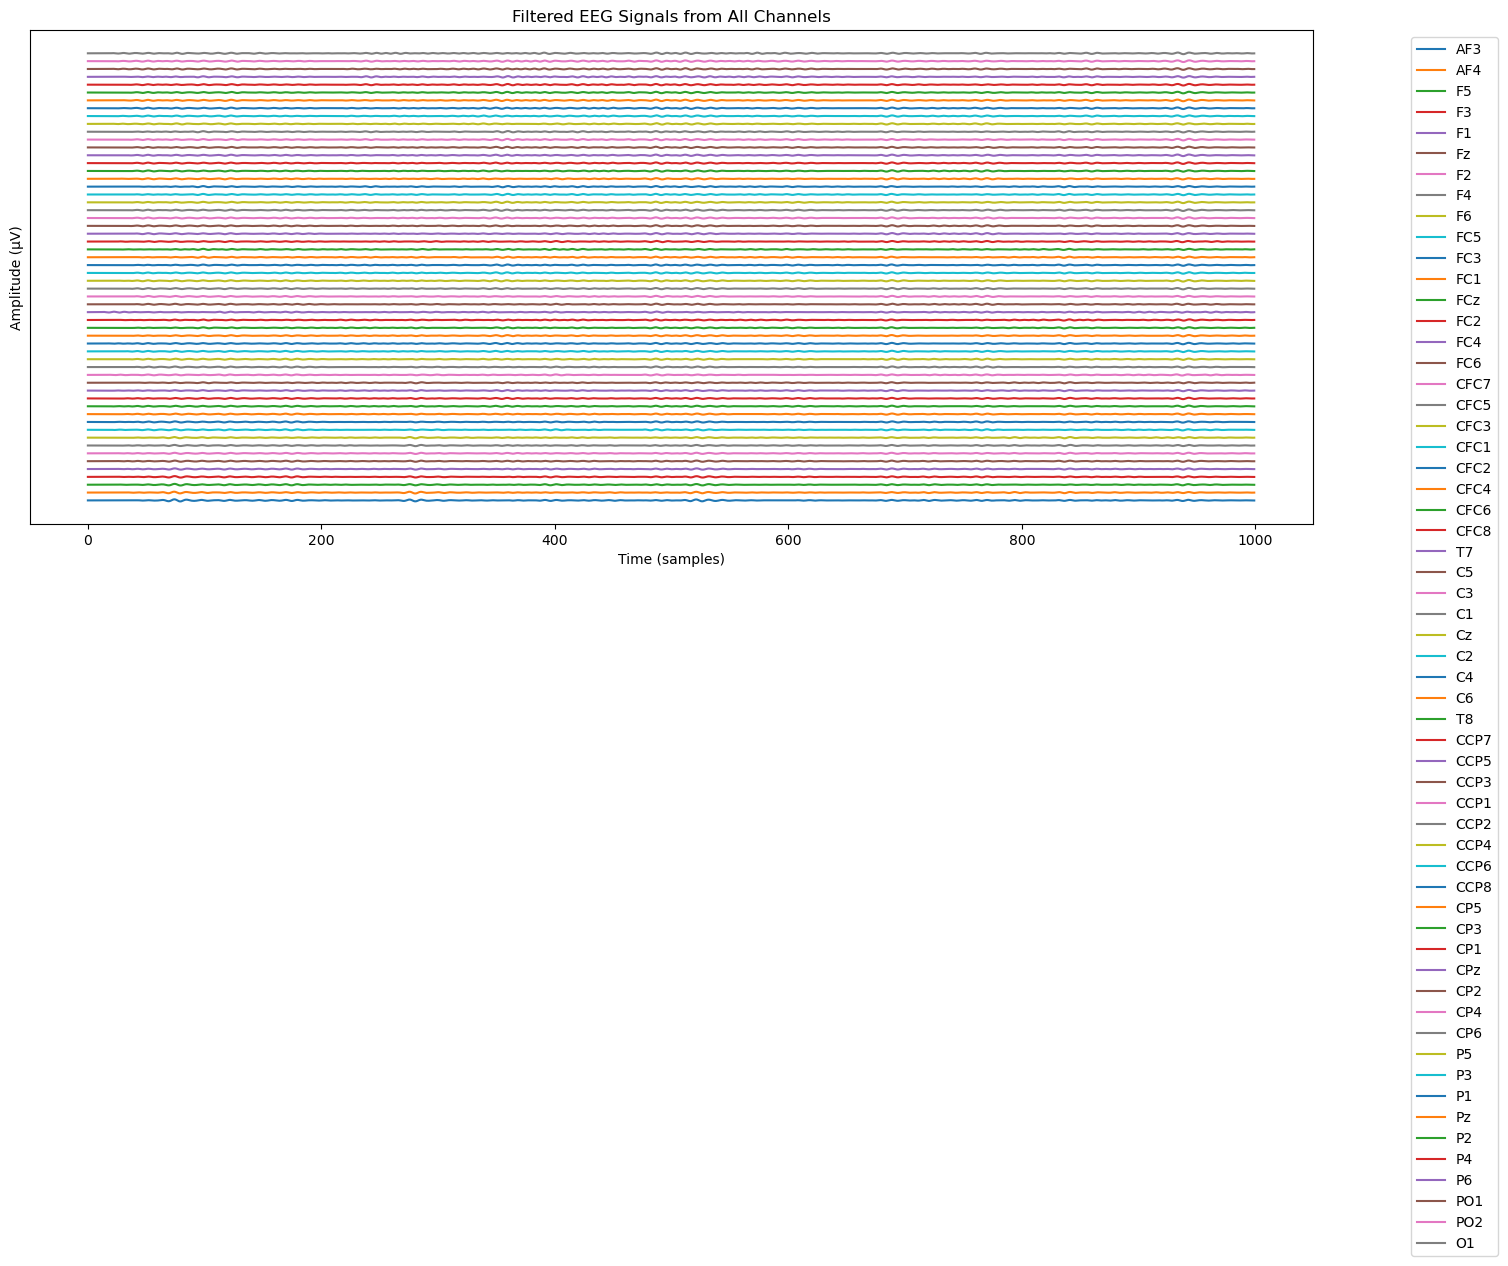

In [4]:
# Define the range of samples to plot
sample_range = range(1000)  

# Get the list of all channel names 
channels = calib_df_filtered.columns[:-1]

# Set up the plot
plt.figure(figsize=(15, 10))

# Define a vertical offset for each channel
offset = 200  

# Plot each channel with a vertical offset
for i, channel in enumerate(channels):
    plt.plot(calib_df_filtered[channel].iloc[sample_range] + i * offset, label=f'{channel}')

#the plot
plt.title('Filtered EEG Signals from All Channels')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (µV)')
plt.yticks([])  # Hide y-axis labels for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)  # Place legend outside the plot
plt.tight_layout()

plt.show()


In [5]:
# Select specific channels
selected_channels = ['C3', 'C4', 'Cz']
calib_df_selected = calib_df_filtered[selected_channels]

# Define the window to include the baseline period and the motor imagery task
baseline_start = -200  # 2 seconds before the marker (assuming 100 Hz sampling rate)
trials_start = 0  # Start at the marker
trials_end = 400  # End 400 samples after the marker (100 Hz sampling rate, 4 seconds)

# Extract trials including the baseline period
trials = []
for i, pos in enumerate(marker_pos):
    start_idx = pos + baseline_start
    end_idx = pos + trials_end
    trial = calib_df_selected.iloc[start_idx:end_idx]
    trials.append(trial)

# Convert to a 3D array
trials_array = np.array([trial.values for trial in trials])

# Step 2: Baseline correction
baseline_corrected_trials = []
for trial in trials_array:
    baseline = trial[:200, :].mean(axis=0)  # Mean of the first 2 seconds (200 samples)
    baseline_corrected_trial = trial - baseline
    baseline_corrected_trials.append(baseline_corrected_trial)

baseline_corrected_trials_array = np.array(baseline_corrected_trials)

# Print shape of the extracted and baseline-corrected trials
print("Shape of the baseline-corrected trials array:", baseline_corrected_trials_array.shape)



Shape of the baseline-corrected trials array: (1400, 600, 3)


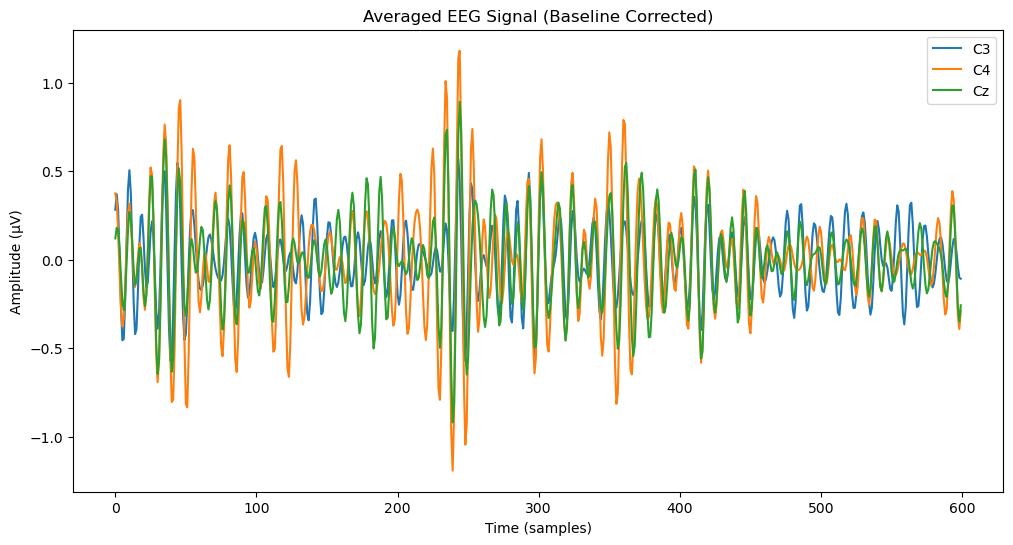

In [6]:

# Averaging across trials
avg_c3 = baseline_corrected_trials_array[:, :, 0].mean(axis=0)
avg_c4 = baseline_corrected_trials_array[:, :, 1].mean(axis=0)
avg_cz = baseline_corrected_trials_array[:, :, 2].mean(axis=0)

#Plotting the averaged signals
plt.figure(figsize=(12, 6))
plt.plot(avg_c3, label='C3')
plt.plot(avg_c4, label='C4')
plt.plot(avg_cz, label='Cz')
plt.title('Averaged EEG Signal (Baseline Corrected)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.show()

In [7]:
# Define the ERD time window based on visual inspection
erd_start = 200  
erd_end = 350  

# Prepare lists to hold ERD features and corresponding labels for all trials
X = []  # Feature vectors for all trials
y = []  # Labels for all trials

# Iterate over each baseline-corrected trial
for i, trial in enumerate(baseline_corrected_trials_array):
    # Extract the signals for C3, C4, and Cz channels within this trial
    c3_signal = trial[:, 0]  # C3 channel
    c4_signal = trial[:, 1]  # C4 channel
    cz_signal = trial[:, 2]  # Cz channel
    
    # Extract the ERD features using the identified ERD time window
    erd_features_c3 = c3_signal[erd_start:erd_end]
    erd_features_c4 = c4_signal[erd_start:erd_end]
    erd_features_cz = cz_signal[erd_start:erd_end]
    
    # Combine features from all channels into a single feature vector
    erd_features = np.concatenate([erd_features_c3, erd_features_c4, erd_features_cz])
    X.append(erd_features)
    
    # Append the corresponding label for this trial
    y.append(marker_labels[i])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Print shapes to verify
print("Shape of X (feature matrix):", X.shape)
print("Shape of y (labels):", y.shape)


Shape of X (feature matrix): (1400, 450)
Shape of y (labels): (1400,)


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Optionally, print a few sample data points to inspect
print("\nSample of X_train:")
print(X_train[:2])  # Print first 2 training samples

print("\nSample of y_train:")
print(y_train[:2])  # Print first 2 training labels

print("\nSample of X_test:")
print(X_test[:2])  # Print first 2 test samples

print("\nSample of y_test:")
print(y_test[:2])  # Print first 2 test labels


Shape of X_train: (1120, 450)
Shape of y_train: (1120,)
Shape of X_test: (280, 450)
Shape of y_test: (280,)

Sample of X_train:
[[ 9.68842510e+00  9.72767493e+00  5.78527916e+00 -1.65584874e-01
  -5.34009608e+00 -7.48597975e+00 -5.95005424e+00 -1.92209475e+00
   2.28228268e+00  4.50755674e+00  3.88078168e+00  1.14186600e+00
  -1.94694404e+00 -3.68339064e+00 -3.32314319e+00 -1.31273879e+00
   1.15986975e+00  2.91574743e+00  3.35675594e+00  2.58323349e+00
   1.11081022e+00 -5.25768018e-01 -1.98917694e+00 -3.08505233e+00
  -3.58414689e+00 -3.16465552e+00 -1.60660747e+00  8.73209766e-01
   3.44763934e+00  4.92158490e+00  4.35643656e+00  1.72319701e+00
  -1.87027028e+00 -4.62329583e+00 -4.99679289e+00 -2.65774361e+00
   1.17742724e+00  4.29288910e+00  4.69242120e+00  1.82852698e+00
  -2.89783918e+00 -6.74956474e+00 -7.13352249e+00 -3.15934502e+00
   3.63159728e+00  9.86396023e+00  1.20222468e+01  8.36719313e+00
   1.91397893e-02 -9.42479530e+00 -1.55713900e+01 -1.53466676e+01
  -8.49035061e

In [9]:
import numpy as np
# Verify that the labels are distributed properly
unique, counts_train = np.unique(y_train, return_counts=True)
unique, counts_test = np.unique(y_test, return_counts=True)
unique, counts_full = np.unique(y, return_counts=True)

# Print the distribution of labels
print("Distribution of labels in the full dataset:")
print(dict(zip(unique, counts_full)))

print("\nDistribution of labels in the training set:")
print(dict(zip(unique, counts_train)))

print("\nDistribution of labels in the test set:")
print(dict(zip(unique, counts_test)))


Distribution of labels in the full dataset:
{-1: 700, 1: 700}

Distribution of labels in the training set:
{-1: 557, 1: 563}

Distribution of labels in the test set:
{-1: 143, 1: 137}


In [10]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Perform a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Initialize the SVM model
svm = SVC(kernel='rbf', C=1, gamma='scale')

# Train the model on the training data
print("Training the SVM model...")
svm.fit(X_train, y_train)

# Predict on the test data
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

# Optional: Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Shape of X_train: (1120, 450)
Shape of y_train: (1120,)
Shape of X_test: (280, 450)
Shape of y_test: (280,)
Training the SVM model...
Test Set Accuracy: 51.07%

Classification Report:
              precision    recall  f1-score   support

          -1       0.51      0.53      0.52       140
           1       0.51      0.49      0.50       140

    accuracy                           0.51       280
   macro avg       0.51      0.51      0.51       280
weighted avg       0.51      0.51      0.51       280



In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Train the model on the training data
lda.fit(X_train, y_train)

# Predict on the test data
y_pred = lda.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"LDA Test Set Accuracy: {accuracy * 100:.2f}%")

# Optional: Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


LDA Test Set Accuracy: 50.71%

Classification Report:
              precision    recall  f1-score   support

          -1       0.51      0.53      0.52       140
           1       0.51      0.49      0.50       140

    accuracy                           0.51       280
   macro avg       0.51      0.51      0.51       280
weighted avg       0.51      0.51      0.51       280



In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the k-NN model
knn = KNeighborsClassifier(n_neighbors=200)  # You can adjust the number of neighbors

# Train the model on the training data
knn.fit(X_train, y_train)

# Predict on the test data
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"k-NN Test Set Accuracy: {accuracy * 100:.2f}%")

# Optional: Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

k-NN Test Set Accuracy: 54.64%

Classification Report:
              precision    recall  f1-score   support

          -1       0.53      0.80      0.64       140
           1       0.59      0.29      0.39       140

    accuracy                           0.55       280
   macro avg       0.56      0.55      0.52       280
weighted avg       0.56      0.55      0.52       280



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Test Set Accuracy: {accuracy * 100:.2f}%")

# Optional: Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Test Set Accuracy: 52.86%

Classification Report:
              precision    recall  f1-score   support

          -1       0.53      0.53      0.53       140
           1       0.53      0.53      0.53       140

    accuracy                           0.53       280
   macro avg       0.53      0.53      0.53       280
weighted avg       0.53      0.53      0.53       280

